In [1]:
import os
import torch
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision import tv_tensors
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms.v2 import functional as F

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

In [3]:
print(torch.cuda.is_available())

True


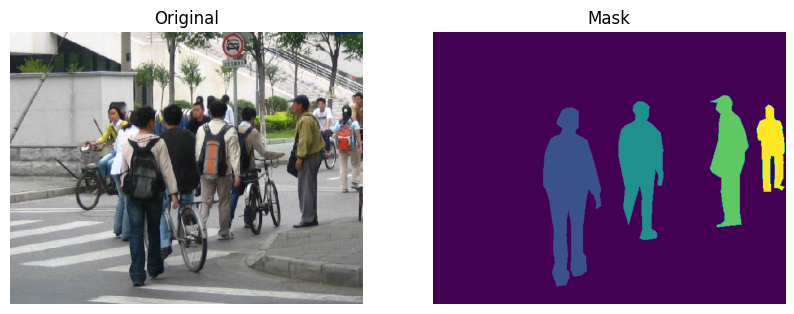

In [4]:
image = read_image("/content/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("/content/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image.permute(1,2,0))
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask.permute(1,2,0))
plt.title('Mask')
plt.axis('off')

plt.show()

In [5]:
class PennDataset(torch.utils.data.Dataset):

  def __init__(self,root,transforms):
      self.root = root
      self.transforms = transforms
      self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
      self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
  def __getitem__(self,idx):
      img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
      mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
      image = read_image(img_path)
      mask = read_image(mask_path)

      obj_id = torch.unique(mask)

      obj_id = obj_id[1:]
      num_objs = len(obj_id)
      masks = (mask == obj_id[:, None, None]).to(dtype=torch.uint8)
      boxes = masks_to_boxes(masks)
      labels = torch.ones((num_objs), dtype=torch.int64)
      image_id = idx
      area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
      iscrowd = torch.zeros((num_objs), dtype=torch.int64)

      img = tv_tensors.Image(image)
      target = {}
      target["boxes"] = tv_tensors.BoundingBoxes(boxes, format = "XYXY", canvas_size= F.get_size(img))
      target["masks"] = tv_tensors.Mask(masks)
      target["labels"] = labels
      target["iscrowd"] = iscrowd
      target["area"] = area
      target["image_id"] = image_id

      if self.transforms is not None:
          img, target = self.transforms(img, target)
      return img, target

  def __len__(self):
          return len(self.imgs)


In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 139MB/s]


In [8]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes = ((32, 64, 128, 256, 512),),
    aspect_ratios = ((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
    )
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator = anchor_generator,
    box_roi_pool = roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 49.7MB/s]


In [24]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes
  )
  return model

In [11]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [25]:
from torchvision.transforms import v2 as T

def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float32, scale=True))
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

In [26]:
!pip install utils
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennDataset('/content/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.2532, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0362, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0079, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0017, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [27]:
import sys
sys.parh.append('/content/')
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
dataset = PennDataset('/content/PennFudanPed', get_transform(train=True))
dataset_test = PennDataset('/content/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:50])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn = utils.collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn = utils.collate_fn
)


model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 4
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

  torch.save(model.state_dict(), f'model_{epoch}.pth')

ERROR: Could not find a version that satisfies the requirement engine (from versions: none)
ERROR: No matching distribution found for engine


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/25]  eta: 0:01:47  lr: 0.000213  loss: 4.0415 (4.0415)  loss_classifier: 0.8712 (0.8712)  loss_box_reg: 0.1958 (0.1958)  loss_mask: 2.9461 (2.9461)  loss_objectness: 0.0145 (0.0145)  loss_rpn_box_reg: 0.0137 (0.0137)  time: 4.3075  data: 0.0563  max mem: 2726
Epoch: [0]  [10/25]  eta: 0:00:13  lr: 0.002294  loss: 1.5947 (2.1137)  loss_classifier: 0.3747 (0.4964)  loss_box_reg: 0.2513 (0.2829)  loss_mask: 0.8223 (1.3003)  loss_objectness: 0.0155 (0.0261)  loss_rpn_box_reg: 0.0083 (0.0080)  time: 0.8821  data: 0.0302  max mem: 2766
Epoch: [0]  [20/25]  eta: 0:00:03  lr: 0.004376  loss: 0.7914 (1.3873)  loss_classifier: 0.1906 (0.3142)  loss_box_reg: 0.2272 (0.2393)  loss_mask: 0.3131 (0.8029)  loss_objectness: 0.0164 (0.0236)  loss_rpn_box_reg: 0.0068 (0.0074)  time: 0.5265  data: 0.0278  max mem: 2766
Epoch: [0]  [24/25]  eta: 0:00:00  lr: 0.005000  loss: 0.6172 (1.2537)  loss_classifier: 0.1483 (0.2791)  loss_box_reg: 0.2308 (0.2344)  loss_mask: 0.2725 (0.7110)  loss_ob

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

  image = (255.0 * (image-image.min())/ (image.max()-image.min())).to(torch.uint8)
  image = image[:3, ...]

  pred_labels = [f"pedestrian : {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
  pred_boxes = pred["boxes"].long()
  result_image = draw_bounding_boxes(image, pred_labels, pred_boxes, color="green")

  mask = (pred["masks"]>0.7).squeeze(1)
  result_image = draw_bounding_boxes(result_image, mask, alpha=0.5,  color="blue")

  plt.figure(figsize=(12,12))
  plt.imshow(result_image.permute(1,2,0))